# 1 Motivation of this notebook

In this file I want to try to solve our problem using two innovative techniques: AutoML and LSTM. We will compare the results of these models with the performance of gradient boosting (baseline model). If AutoML wins, it means that the idea underlying it really works in the context of the task. If LSTM wins, it means that there are complex patterns in the data, and it is necessary to study them using complex methods

# 2 AutoML

Remember that a typical Machine Learning pipeline might look very complicated and involves at least several necessary steps. We need to preprocess the data, to choose a model, to optimize hyperparameters, to test the quality, and to deploy the model. This is why a big trend in Data Science is to try optimize these steps. As a result, it will be faster for DS-people to do the job, or it will even allow non-technical people to solve these tasks. So, AutoML is a collection of methods to automate as many things as possible while going through ML-pipeline

We will use built-in H2O Python library (https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/intro.html). This module is quite specific, and it is not so easy to use it on a local machine. Therefore, it seems to me that it does not solve the need for convenience and simplicity. At the same time, it can still quickly select the optimal model and hyperparameters. Here are some advantages and disadvantages of the library:

### 2.1 Advantages of H2O Python library:

1) In general, it solves the problem of finding optimal hyperparameters and models

2) Nice interpretation of the results (metrics and feature importance)

3) Optimality and compatibility with Spark

### 2.2 Drawbacks of the module:

1) Not a very wide selection of models. For example, I cannot choose CatBoost there. In some tasks we need specific algorithms which might be missing in H2O, which is bad

2) The library is not for beginners. It was more complicated to do the iterative prediction process on the test sample, than it was in case of CatBoost. We need to convert the data into special H2O dataframe format 

3) It might be complicated to run it on a local machine

### 2.3 Getting ready

In [ ]:
! pip install h2o

In [ ]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2


df = pd.read_csv('dataset_with_lags_no_leak.csv')
df = df.iloc[:, 1:]
df

,postcode,propertyType,bedrooms,datesold_year,month,price,lag1,lag2,lag3,lag6,lag12,lag24,lag36
0,7,0,4,2007,2,13.171154,13.550983,13.548695,13.548638,13.543946,13.533265,13.508225,13.493080
1,22,0,3,2007,2,12.577636,12.940417,12.939460,12.937895,12.933091,12.925453,12.910905,12.897718
2,21,0,3,2007,3,12.700769,12.993368,12.993778,12.992181,12.987281,12.979764,12.961663,12.948609
3,21,0,4,2007,3,12.847927,13.235014,13.233358,13.231306,13.227763,13.219576,13.198490,13.187284
4,22,0,3,2007,3,12.644328,12.577636,12.939460,12.937895,12.933091,12.925453,12.910905,12.897718
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9251,25,0,5,2019,7,13.832122,0.000000,0.000000,0.000000,0.000000,13.803775,13.527828,13.407542
9252,25,1,2,2019,7,12.836014,0.000000,0.000000,0.000000,0.000000,12.860999,12.786891,12.487108
9253,26,0,3,2019,7,13.076843,0.000000,0.000000,0.000000,0.000000,13.239753,13.252993,13.137580
9254,26,0,4,2019,7,13.479727,0.000000,0.000000,0.000000,0.000000,13.508850,13.523403,13.405221


In [ ]:
def get_datasets(df):
  train = df.loc[df['datesold_year'] < 2018]
  valid = df.loc[df['datesold_year'] == 2018]
  test = df.loc[df['datesold_year'] == 2019]
  X_train = train.drop('price', axis=1)
  y_train = train[['price']]
  X_valid = valid.drop('price', axis=1)
  y_valid = valid[['price']]
  X_test = test.drop('price', axis=1)
  y_test = test[['price']]
  return X_train, y_train, X_valid, y_valid, X_test, y_test

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = get_datasets(df)

In [ ]:
X_train.shape, X_valid.shape

((7726, 12), (1044, 12))

### 2.4 Creating the model

The process of training the model is fairly standard. We will create a learning environment using H2OAutoML. To control overfitting, we will have a validation sample, but we will not do cross-validation (by setting nfolds = 0). This is done in order not to look in the future. When working with time series, we can use special cross-validation on time series technique, but we will not do this now. We will also exclude the option of using Deep Learning (I tried doing with it before, and the Deep Learning was chosen as the best option, but the results on the test were bad, which indicates that it was not possible to prevent overfitting and the model probably just memorized the training and validation sets)

In [ ]:
h2o.init()
train = df.loc[df['datesold_year'] < 2018]
valid = df.loc[df['datesold_year'] == 2018]
test = df.loc[df['datesold_year'] == 2019]

X_test = test.drop('price', axis=1)
y_test = test[['price']]

train = h2o.H2OFrame(train)
valid = h2o.H2OFrame(valid)
test = h2o.H2OFrame(test)

target_col = "price"

automl = H2OAutoML(max_models=30, seed=42, nfolds=0, exclude_algos = ["DeepLearning"], stopping_rounds=20)
automl.train(x=train.columns.remove(target_col), y=target_col, training_frame=train, validation_frame=valid)

best_model = automl.leader

X_test.index = np.arange(0, len(X_test))
y_pred_test = []

for i in range(len(X_test)):
    row = X_test.iloc[i:i+1]

    pred = best_model.predict(h2o.H2OFrame(row))
    y_pred_test.append(pred[0, 0])

    month = row['month'].iloc[0]
    propertyType = row['propertyType'].iloc[0]
    bedrooms = row['bedrooms'].iloc[0]
    postcode = row['postcode'].iloc[0]

    for j in range(len(X_test)):
        if X_test['propertyType'][j] == propertyType and \
           X_test['bedrooms'][j] == bedrooms and \
           X_test['postcode'][j] == postcode:

            if X_test['month'][j] == month + 1 and X_test['lag1'][j] == 0:
                X_test['lag1'][j] = pred[0, 0]

            elif X_test['month'][j] == month + 2 and X_test['lag2'][j] == 0:
                X_test['lag2'][j] = pred[0, 0]

            elif X_test['month'][j] == month + 3 and X_test['lag3'][j] == 0:
                X_test['lag3'][j] = pred[0, 0]

            elif X_test['month'][j] == month + 6 and X_test['lag6'][j] == 0:
                X_test['lag6'][j] = pred[0, 0]


In [ ]:
h2o.save_model(model=best_model, force=True) # save the model so we can use it in the future

h2o.shutdown()

H2O session _sid_90e1 closed.


<ipython-input-7-f5138c4d4576>:3: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()


MAPE: 17.74%

MAE: 128260.5589784658


Text(0.5, 1.0, 'Compare predictions and real values on the TEST set')

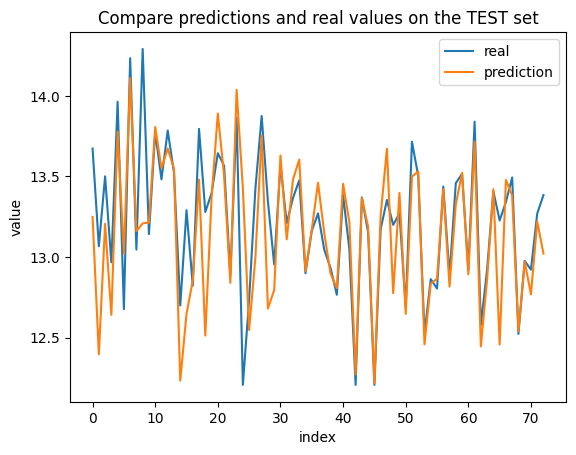

In [ ]:
print(f'MAPE: {np.round(mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred_test)) * 100, 2)}%')
print()
print(f'MAE: {mean_absolute_error(np.exp(y_test), np.exp(y_pred_test))}')
compare_preds_test_df = pd.DataFrame([y_test['price'].tolist(), y_pred_test]).T
compare_preds_test_df.columns = ['real', 'prediction']
compare_preds_test_df = compare_preds_test_df.sample(frac=.15)
compare_preds_test_df = compare_preds_test_df.reset_index()
compare_preds_test_df = compare_preds_test_df.drop('index', axis=1)
compare_preds_test_df.plot(legend=True)
plt.xlabel('index')
plt.ylabel('value')
plt.title('Compare predictions and real values on the TEST set')

In [ ]:
best_model

,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,50.0,50.0,2509111.0,20.0,20.0,20.0,3744.0,4216.0,3995.26
,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2023-07-21 20:22:59,0.052 sec,0.0,nan,nan,nan,nan,nan,nan
,2023-07-21 20:23:00,1.323 sec,5.0,0.2149786,0.1524427,0.0462158,0.1838095,0.1256901,0.0337859
,2023-07-21 20:23:01,1.939 sec,10.0,0.1937493,0.1380438,0.0375388,0.1763143,0.1183850,0.0310867
,2023-07-21 20:23:02,2.540 sec,15.0,0.1850227,0.1315937,0.0342334,0.1750877,0.1147577,0.0306557
,2023-07-21 20:23:02,3.129 sec,20.0,0.1812798,0.1281781,0.0328624,0.1740419,0.1139012,0.0302906
,2023-07-21 20:23:03,3.574 sec,25.0,0.1786692,0.1257271,0.0319227,0.1734912,0.1132623,0.0300992
,2023-07-21 20:23:03,4.022 sec,30.0,0.1767584,0.1243428,0.0312435,0.1741062,0.1131598,0.0303130
,2023-07-21 20:23:04,4.481 sec,35.0,0.1758106,0.1236333,0.0309094,0.1725863,0.1123739,0.0297860


### 2.5 Results

Let me remind that in case of baseline model the results were following:

MAPE: 17.88%

MAE: 130094.95169371304

All in all, we have improvements, although not significant. However, there is one important thing to take into account. Let's look at the parameters of the final model (RandomForest). The depth of tree is 20, which seems a lot, given that our dataset is small. So, although the quality is good, the model seems to be overfitted. Also, as the number of trees is not very big (just 50), the variance does not seem to be reduced much. That is why, it is a good idea to try to build our own random forest regressor by increasing the number of trees and reducing their maximum depth to see what happens

### 2.6 Was it worth it?

In my opinion, the use of the library was justified. Despite its limitations, we were able to understand that using a random forest as part of a task might be a good idea. In addition, we also got a lot of metrics and the importance of features, which can also be useful. This is the advantage of the library - it is faster to run this pipeline than to calculate all the metrics by our own and get the importance of features. Therefore, it seems to me that this is a good addition to the analysis

As we see, lags are the most important features, and the nearest ones give us the most information. Furthermore, looking one year back is more reasonable than seeing what was happening long time ago. Finally, according to model, bedrooms and propertyType features are the least important, which was strange for me a little

# Bonus

While I was writing this notebook, there was one more major event in the world of Large Language Models (LLMs) - LLaMA 2 was invented

However, now I want to move one step back and say that H2O has its own version of ChatGPT. I found a video where a person explains how to run it on a local machine (https://www.youtube.com/watch?v=Coj72EzmX20&t=18s)

I am very interested in NLP tasks, as well as transformers and LLMs, and I am planning to do a big end-to-end project on this. However, now let's move to LSTM

# 3 LSTM

LSTM is a type of neural network arhitecture, which is capable of finding patterns and dependencies in sequences. That is why they are useful in time series problems, as well as in NLP, audio, and some generative AI problems. LSTM is a special type of RNN class of neural networks, designed to solve several issues with classical RNN

### 3.1 Problems with RNNs and how LSTM can solve them

Let's remember how a recurrent neural network looks like, and what it is 

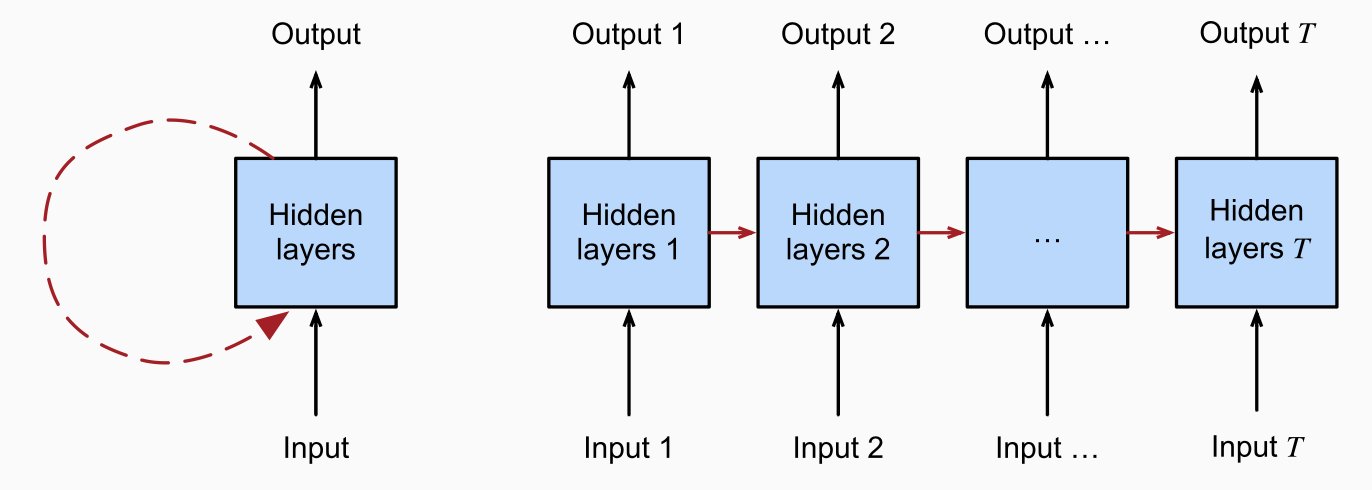

In [1]:
# The picture of RNN
from IPython.display import Image, display
display(Image(filename='RNN.png'))

As we see, previous hidden layers affect the current ones. We will not dive into deep details, but in general it looks like this:

$$h_{t} = f_w(x_t + h_{t-1}),$$

where $f_w$ is a function with weights $w$, and the current cell state $h_t$ depends on the input and the previous state. Since we have a lot of terms, the optimization process becomes complicated and messy

When we do backpropagation, we need to go through individual time steps, which depend on other time steps (this is called backpropagation through time). That is why we will multiply many terms together. This causes two potential problems:

1) $\textbf{Exploding gradient problem}$: if there are many individual gradients, which are greater of far greater than 1,
we might end up with huge gradients overall. The possible solution is gradient clipping, when we set an upper bound on the values of gradients

2) $\textbf{Vanishing gradient problem}$: In contrast, if there are many terms that are less than 1, we can end up with gradients being nearly 0. There are several possible solutions, including changing the activation function or the network architecture

These problems can lead to difficulties in training the model on long sequences, since it will be difficult to study dependencies correctly on long time intervals. Therefore, an LSTM architecture has been proposed, which is a solution to these problems. The key difference is that LSTM has one more component - a cell state, and uses gates to control the flow of information. As a result, it is able to get rid of irrelevant information, while maintaining the information we need

### 3.2 Why the model most likely will not work in this situation

Despite the fact that LSTM captures long-term dependencies in sequential data well, which makes it a good tool in many Machine Learning tasks, it has its limitations. As in most cases, neural networks usually require a huge amount of data, since on a small datasets they may either not find complex patterns, or they may overfit, which is not good. Our dataset is quite small. That is why, I do not expect LSTM to perform very well, and I will be concerned about overfitting. Hence, we will start with very simple models, making them more and more complex, if it is necessary

When it comes to time series, LSTM looks at a certain number of steps back, that is, it should analyze one time series (which can also be multivariate). We have panel data, that is, a lot of time series at one table, and it does not make sense to look at a certain number of steps back, since these will be completely different objects in the context of the task. We have lag features, but still using LSTM makes no sense. To solve the problem, we can split our dataset into individual time series (we will do this when using statistical models such as ARIMA), predicting them separately. However, in the case of LSTM, there will be too little data for each model, so we will still try to train the model on the entire dataset to see if it works

Let's write some functions which we will use to make predictions and evaluate model on the test set

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = get_datasets(df)

In [ ]:
def make_preds_LSTM(model, X_test):
  X_test.index = np.arange(0, len(X_test))
  y_pred_test = []

  for i in range(len(X_test)):

      pred = model.predict(X_test.iloc[i:i+1])[0][0]

      month = X_test['month'][i]
      propertyType = X_test['propertyType'][i]
      bedrooms = X_test['bedrooms'][i]
      postcode = X_test['postcode'][i]

      y_pred_test.append(pred)

      for j in range(len(X_test)):

          if X_test['propertyType'][j] == propertyType\
          and X_test['bedrooms'][j] == bedrooms\
          and X_test['postcode'][j] == postcode:

              if X_test['month'][j] == month + 1 and X_test['lag1'][j] == 0:
                  X_test['lag1'][j] = pred

              elif X_test['month'][j] == month + 2 and X_test['lag2'][j] == 0:
                  X_test['lag2'][j] = pred

              elif X_test['month'][j] == month + 3 and X_test['lag3'][j] == 0:
                  X_test['lag3'][j] = pred

              elif X_test['month'][j] == month + 6 and X_test['lag6'][j] == 0:
                  X_test['lag6'][j] = pred
  return y_pred_test

In [ ]:
def evaluate_LSTM(y_test, y_pred_test):
  print(f'MAPE: {np.round(mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred_test)) * 100, 2)}%')
  print()
  print(f'MAE: {mean_absolute_error(np.exp(y_test), np.exp(y_pred_test))}')
  compare_preds_test_df = pd.DataFrame([y_test['price'].tolist(), y_pred_test]).T
  compare_preds_test_df.columns = ['real', 'prediction']
  compare_preds_test_df = compare_preds_test_df.sample(frac=.15)
  compare_preds_test_df = compare_preds_test_df.reset_index()
  compare_preds_test_df = compare_preds_test_df.drop('index', axis=1)
  compare_preds_test_df.plot(legend=True)
  plt.xlabel('index')
  plt.ylabel('value')
  plt.title('Compare predictions and real values on the TEST set')

### 3.3 Training process

We will start with very simple model to see what is going on

In [ ]:
# The simplest model possible
X_train, y_train, X_valid, y_valid, X_test, y_test = get_datasets(df)
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(X_train.shape[1], 1)), #128
    tf.keras.layers.Dense(1)
])

loss_function = tf.keras.losses.MeanSquaredError()

optimizer = tf.keras.optimizers.Adam()

batch_size = 64
num_epochs = 15

X_train = X_train.values.reshape(-1, X_train.shape[1], 1)
X_valid = X_valid.values.reshape(-1, X_valid.shape[1], 1)

model.compile(optimizer=optimizer, loss=loss_function)

model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_valid, y_valid))

Epoch 1/15
121/121 [==============================] - 5s 19ms/step - loss: 57.5475 - val_loss: 1.7999
Epoch 2/15
121/121 [==============================] - 5s 38ms/step - loss: 0.3164 - val_loss: 0.2224
Epoch 3/15
121/121 [==============================] - 2s 15ms/step - loss: 0.1623 - val_loss: 0.2214
Epoch 4/15
121/121 [==============================] - 2s 15ms/step - loss: 0.1622 - val_loss: 0.2213
Epoch 5/15
121/121 [==============================] - 2s 16ms/step - loss: 0.1622 - val_loss: 0.2215
Epoch 6/15
121/121 [==============================] - 2s 16ms/step - loss: 0.1621 - val_loss: 0.2231
Epoch 7/15
121/121 [==============================] - 1s 12ms/step - loss: 0.1620 - val_loss: 0.2227
Epoch 8/15
121/121 [==============================] - 2s 16ms/step - loss: 0.1619 - val_loss: 0.2211
Epoch 9/15
121/121 [==============================] - 2s 18ms/step - loss: 0.1618 - val_loss: 0.2201
Epoch 10/15
121/121 [==============================] - 1s 12ms/step - loss: 0.1618 - val_l

In [ ]:
y_pred_test = make_preds_LSTM(model, X_test)

MAPE: 36.28%

MAE: 222103.33456924304


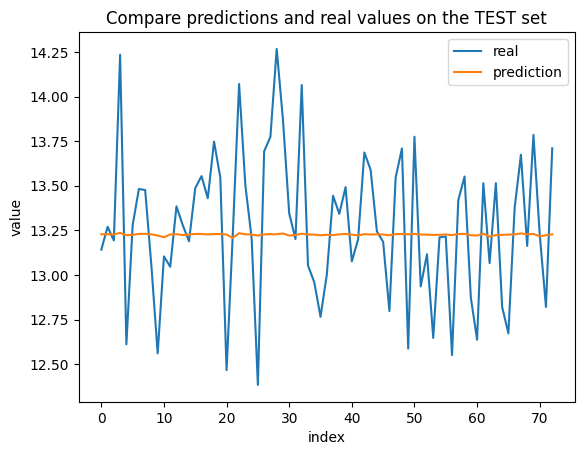

In [ ]:
evaluate_LSTM(y_test, y_pred_test)

As we see, the model is too simple and it gives approximately constant predictions. That is why we will increase the batch size and number of epochs 

In [ ]:
# A bit more complicated model
X_train, y_train, X_valid, y_valid, X_test, y_test = get_datasets(df)
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.Dense(1)
])

loss_function = tf.keras.losses.MeanSquaredError()

optimizer = tf.keras.optimizers.Adam()

batch_size = 128
num_epochs = 40

X_train = X_train.values.reshape(-1, X_train.shape[1], 1)
X_valid = X_valid.values.reshape(-1, X_valid.shape[1], 1)

model.compile(optimizer=optimizer, loss=loss_function)

model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_valid, y_valid))

Epoch 1/40
61/61 [==============================] - 7s 74ms/step - loss: 37.8054 - val_loss: 0.3815
Epoch 2/40
61/61 [==============================] - 2s 38ms/step - loss: 0.2149 - val_loss: 0.2254
Epoch 3/40
61/61 [==============================] - 2s 38ms/step - loss: 0.1667 - val_loss: 0.2282
Epoch 4/40
61/61 [==============================] - 2s 38ms/step - loss: 0.1664 - val_loss: 0.2265
Epoch 5/40
61/61 [==============================] - 3s 41ms/step - loss: 0.1660 - val_loss: 0.2266
Epoch 6/40
61/61 [==============================] - 4s 61ms/step - loss: 0.1657 - val_loss: 0.2245
Epoch 7/40
61/61 [==============================] - 2s 39ms/step - loss: 0.1652 - val_loss: 0.2276
Epoch 8/40
61/61 [==============================] - 2s 38ms/step - loss: 0.1648 - val_loss: 0.2278
Epoch 9/40
61/61 [==============================] - 2s 38ms/step - loss: 0.1646 - val_loss: 0.2232
Epoch 10/40
61/61 [==============================] - 2s 39ms/step - loss: 0.1641 - val_loss: 0.2242
Epoch 11

In [ ]:
y_pred_test = make_preds_LSTM(model, X_test)

MAPE: 28.18%

MAE: 216807.20600861034


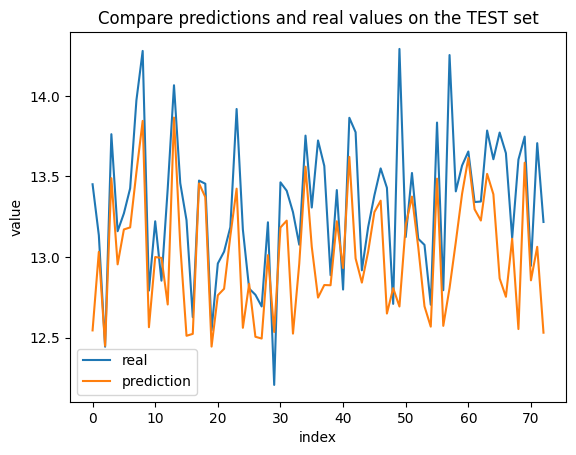

In [ ]:
evaluate_LSTM(y_test, y_pred_test)

Now it is much better. However, the results are bad compared to CatBoost and AutoML. Hence, we need to try to make model more complex by adding an additional layer and making even more epochs. To control the overfitting, I suggest to make dropout layers (meaning that a fraction of the neurons will not take part in the training process)

In [ ]:
# Hardcore
X_train, y_train, X_valid, y_valid, X_test, y_test = get_datasets(df)
def create_lstm_regression_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, input_shape=(input_shape), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear', kernel_regularizer=l2(0.01)))
    return model


X_train_tensor = tf.constant(X_train.values, dtype=tf.float32)
y_train_tensor = tf.constant(y_train.values, dtype=tf.float32)
X_valid_tensor = tf.constant(X_valid.values, dtype=tf.float32)
y_valid_tensor = tf.constant(y_valid.values, dtype=tf.float32)

input_shape = (X_train.shape[1], 1)
model = create_lstm_regression_model(input_shape)

model.compile(loss='mean_squared_error', optimizer='adam')

epochs = 50
batch_size = 32
history = model.fit(X_train_tensor, y_train_tensor, validation_data=(X_valid_tensor, y_valid_tensor),
                    epochs=epochs, batch_size=batch_size, verbose=1)

score = model.evaluate(X_valid_tensor, y_valid_tensor, batch_size=batch_size, verbose=0)
print(f'Validation loss: {score}')


Epoch 1/50
242/242 [==============================] - 20s 60ms/step - loss: 6.6762 - val_loss: 0.2360
Epoch 2/50
242/242 [==============================] - 13s 55ms/step - loss: 1.7969 - val_loss: 0.2935
Epoch 3/50
242/242 [==============================] - 13s 53ms/step - loss: 1.6696 - val_loss: 0.3148
Epoch 4/50
242/242 [==============================] - 13s 53ms/step - loss: 1.6423 - val_loss: 0.2863
Epoch 5/50
242/242 [==============================] - 13s 53ms/step - loss: 1.6507 - val_loss: 0.2395
Epoch 6/50
242/242 [==============================] - 13s 55ms/step - loss: 1.6160 - val_loss: 0.2323
Epoch 7/50
242/242 [==============================] - 13s 54ms/step - loss: 1.5885 - val_loss: 0.2913
Epoch 8/50
242/242 [==============================] - 13s 54ms/step - loss: 1.5589 - val_loss: 0.2421
Epoch 9/50
242/242 [==============================] - 13s 55ms/step - loss: 1.5442 - val_loss: 0.2570
Epoch 10/50
242/242 [==============================] - 13s 56ms/step - loss: 1.527

In [ ]:
y_pred_test = make_preds_LSTM(model, X_test)

MAPE: 34.36%

MAE: 262649.6468992205


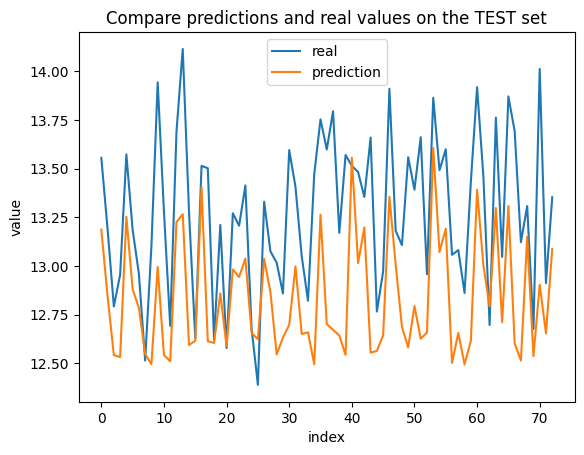

In [ ]:
evaluate_LSTM(y_test, y_pred_test)

The results became worse now. That means that the second option was the best. However, I do not think we will get even close to the results of the baseline model, so we will not spend additional time trying to improve the performance of LSTM

# 4 Summary

Thus, AutoML methods managed to outperform our baseline model in terms of metrics. At the same time, the quality of this solution remains questionable, since the improvements are insignificant, and the output turned out to be a rather strange model, looking like an overfitted one. In the case of LSTM, the experiment was unsuccessful. Most likely, this is due to the complex data structure, which is not quite suitable for the architecture of this neural network, and the small number of objects in the sample

# References

1) https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/intro.html - documentation of the h2o Python library

2) https://www.geeksforgeeks.org/automl-using-h2o/ - AutoML process with h2o

3) https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html, https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM - about LSTM

4) https://www.youtube.com/watch?v=tepxdcepTbY - useful video on how to code LSTM, using Tensorflow

5) https://github.com/AlgazinovAleksandr/Deep-Learning-project - one of my previous projects. There I discuss how to select hyperparameters in neural networks, as well as problems with RNN

6) https://machinelearningmastery.com/gentle-introduction-long-short-term-memory-networks-experts/ - one more article about LSTM

7) https://d2l.ai/chapter_recurrent-neural-networks/index.html - what is RNN, and how it works

8) https://www.youtube.com/watch?v=ySEx_Bqxvvo&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=2 - useful video about RNN and LSTM from MIT's introduction to Deep Learning course